# Data

In [192]:
import pandas as pd
from pathlib import Path

def open_fn(f):
    try:
        return pd.read_csv(f,engine='python')
    except:
        return pd.DataFrame()

files = Path('../data/futurists_kol/data').rglob('*csv')
outs = map(open_fn, files)
outs = pd.concat(outs)
outs.columns = ['index','user','timestamp','url','txt']
outs.reset_index(drop=True,inplace=True)
print(outs['user'].nunique(),len(outs)) # 257 users, 1254244 tweets
outs['txt'] = outs['txt'].astype(str)
outs['timestamp'] = pd.to_datetime(outs['timestamp'])

outs.head()

256 1254243


,index,user,timestamp,url,txt
0,0,@marcuseast,2023-03-11 04:50:26+00:00,https://twitter.com/marcuseast/status/16344164...,@CanonUser101 Beautiful - glad to see that you...
1,1,@marcuseast,2023-03-11 04:49:00+00:00,https://twitter.com/marcuseast/status/16344161...,"@stephr_wong Congratulations, Steph!"
2,2,@marcuseast,2023-03-11 03:17:12+00:00,https://twitter.com/marcuseast/status/16343930...,#ICanVouchFor @lsanger (we have selfies togeth...
3,3,@marcuseast,2023-03-08 23:17:37+00:00,https://twitter.com/marcuseast/status/16336079...,Happy #InternationalWomensDay!\n\nI'm surround...
4,4,@marcuseast,2023-03-08 21:57:08+00:00,https://twitter.com/marcuseast/status/16335876...,@lsanger This is a great - will share with a h...


# Topic Modelling

In [247]:
import multiprocessing as mp
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer(preserve_case=False)

with mp.Pool(4) as pool:
    corpus = pool.map(tokenizer.tokenize, outs['txt'])

In [248]:
from gensim.corpora import Dictionary
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

dictionary = Dictionary(corpus)
bad_ids = list(map(dictionary.token2id.get, stopwords.words('english')))
dictionary.filter_tokens(bad_ids=bad_ids)
dictionary.filter_extremes(no_below=50)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mskorski/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [249]:
with mp.Pool(4) as pool:
    corpus = pool.map(dictionary.doc2bow, corpus)

# Training Model

In [250]:
from gensim.models import LdaMulticore
lda = LdaMulticore(corpus, id2word=dictionary, num_topics=10, workers=3, passes=10)
lda.save('my_model')
#lda = LdaMulticore.load('my_model')

# Visualize Topics

In [251]:
import pyLDAvis
import pyLDAvis.gensim_models
from gensim.corpora import Dictionary

dictionary = Dictionary.from_corpus(corpus, lda.id2word)

pyLDAvis.enable_notebook()
vis_data = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)
vis_data

/home/mskorski/anticipate/anticipatio/.venv/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.137259 -0.150026       1        1  22.056900
8     -0.087964  0.304355       2        1  12.935597
4     -0.009540 -0.171128       3        1  12.051550
9     -0.160313 -0.071172       4        1  10.095625
6      0.385528  0.086666       5        1   9.638096
2      0.057355 -0.257745       6        1   9.553676
7     -0.160413  0.159296       7        1   9.316040
3     -0.065575  0.142867       8        1   5.376555
0     -0.061803 -0.065531       9        1   4.904819
5      0.239983  0.022417      10        1   4.071143, topic_info=                 Term           Freq          Total Category  logprob  loglift
1                   ,  584259.000000  584259.000000  Default  30.0000  30.0000
46                  .  783660.000000  783660.000000  Default  29.0000  29.0000
0                   !  252775.000000  252775.000000  Default  28.0000  28.0000
1471              #ai  180040.000000  180040.000000  Default  27.0000  27.0000
580            change  175106.000000  175106.000000  Default  26.0000  26.0000
...               ...            ...            ...      ...      ...      ...
16260  #100daysofcode    9051.396333   30353.713612  Topic10  -4.4729   1.9912
1241          science    6825.283844   13818.546141  Topic10  -4.7552   2.4959
46                  .   15303.117697  783660.405852  Topic10  -3.9477  -0.7347
371              free    6281.115661   13086.851625  Topic10  -4.8382   2.4672
0                   !    7492.381220  252775.707798  Topic10  -4.6619  -0.3174

[497 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         3  0.032456    !
0         5  0.296547    !
0         6  0.641355    !
0        10  0.029639    !
613       1  0.999983    "
...     ...       ...  ...
855       3  0.999876    📱
150       1  0.999911    😂
340       3  0.999857    😉
568       6  0.999701    😊
186       6  0.999872    🤣

[693 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 9, 5, 10, 7, 3, 8, 4, 1, 6])

# Topic Dynamics

In [4]:
from gensim.models import LdaMulticore
lda = LdaMulticore.load('my_model')

In [243]:
#lda.print_topics()

In [199]:
topic_idxs = list(lda.get_document_topics(corpus))

In [201]:
def job(t):
    return sorted(t, key=lambda t:t[1])[-1][0]


with mp.Pool(4) as pool:
    topics = pool.map(job, topic_idxs)
    
#topics

# Topics over time

In [230]:
#topics

topics_dynamic = pd.DataFrame(zip(outs['timestamp'],topics),columns=['time','topic_id'])
topics_dynamic['time'] = pd.to_datetime(topics_dynamic['time']).dt.date
topics_dynamic = topics_dynamic.groupby(['time','topic_id']).size().rename('counts')
topics_dynamic = topics_dynamic.reset_index()

In [234]:
topics_dynamic['cum_count'] = topics_dynamic.groupby(['time','topic_id'])['counts'].transform(pd.Series.cumsum)

In [238]:
topics_dynamic['cum_count_smooth']=topics_dynamic.groupby(['topic_id']).rolling(window=30,on='time')['cum_count'].mean().reset_index(drop=True)

In [204]:
# outs[:100000].groupby(pd.Grouper(key='timestamp',freq='1D')).size().plot()

<AxesSubplot: xlabel='time', ylabel='cum_count'>

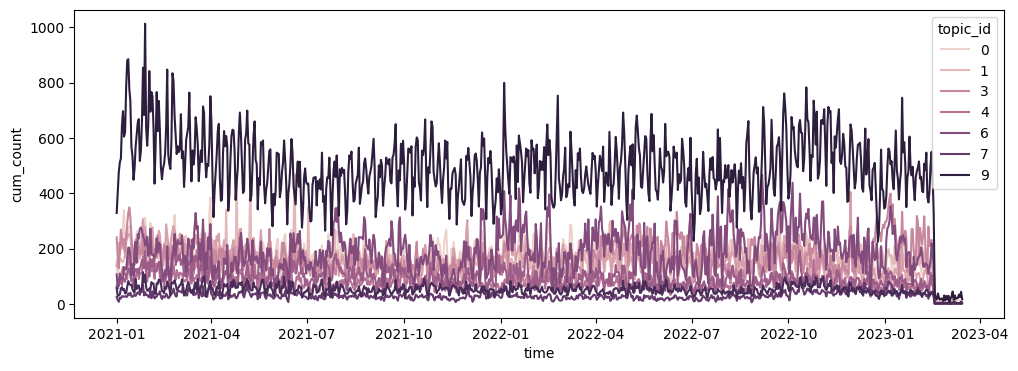

In [240]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(12,4))
sns.lineplot(topics_dynamic, x='time', y='cum_count',hue='topic_id', ax=ax)

In [241]:
fig.savefig('topics_dynamic.png')

In [87]:
#map(lambda topic_dist: sorted(topic_dist,key=lambda t:t[1])[-1][0], lda.get_document_topics(corpus))


def job(t):
    return i,sorted(t, key=lambda t:t[1])[-1][0]

with mp.Pool(4) as pool:
    topic_idxs = pool.map(lda.get_document_topics, corpus[:100000])
    

In [88]:
topic_idxs

[[(0, 0.28614277),
  (4, 0.10331354),
  (6, 0.12422836),
  (8, 0.10999939),
  (9, 0.33783013)],
 [(0, 0.025008256),
  (1, 0.024998594),
  (2, 0.025007715),
  (3, 0.02499975),
  (4, 0.024999978),
  (5, 0.024998594),
  (6, 0.024998594),
  (7, 0.024998594),
  (8, 0.77497476),
  (9, 0.025015155)],
 [(0, 0.17213288),
  (4, 0.13579552),
  (6, 0.42918903),
  (8, 0.023625743),
  (9, 0.2225553)],
 [(0, 0.24104942),
  (4, 0.07169734),
  (5, 0.063322105),
  (6, 0.11587276),
  (7, 0.06713076),
  (8, 0.1637853),
  (9, 0.2594386)],
 [(0, 0.010002822),
  (1, 0.010001148),
  (2, 0.110007934),
  (3, 0.010002707),
  (4, 0.23379478),
  (5, 0.010001434),
  (6, 0.15995212),
  (7, 0.010001175),
  (8, 0.086589724),
  (9, 0.35964617)],
 [(0, 0.02001035),
  (1, 0.020002866),
  (2, 0.020009937),
  (3, 0.24352613),
  (4, 0.020003948),
  (5, 0.020002866),
  (6, 0.020002866),
  (7, 0.020002866),
  (8, 0.59642535),
  (9, 0.020012831)],
 [(0, 0.10639642),
  (2, 0.14507498),
  (3, 0.044848487),
  (4, 0.19723988),
  (

In [55]:
topics = map(lambda topic_dist: sorted(topic_dist,key=lambda t:t[1])[-1][0], lda.get_document_topics(corpus))
topics = list(topics)

KeyboardInterrupt: 

(0, 0.2861139)

In [43]:
sorted(t[0],key=lambda t:t[1])[-1][0]

9

In [9]:
short_words = 
list(w for w,_ in lda.show_topic(topicid=1,topn=30) if len(w)==1)

["'", '️', '.', '?']